In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [434]:
EXP = 40000
SAMPLE_SIZE = 2900  
TAXA_ATUAL = 0.0493
VLR_MINIMO = 4950
IS_ZERO = 119000

print(SAMPLE_SIZE/EXP)

0.0725


In [435]:
[ VLR_MINIMO/is_ for is_ in criar_sequencia_IS(IS_ZERO, [0,1,2,3,4,5,6,7])]

[0.04159663865546218,
 0.04342029087208996,
 0.04532385957844232,
 0.04731092356657459,
 0.04938493310586334,
 0.05155014944336253,
 0.053810196760517445,
 0.0561695753807049]

In [436]:
def gerar_sequencia_idades(sample_size):
    random_sample = np.random.normal(0, 1, sample_size)

    # Normalize the sample between -1 and 15
    normalized_sample = 16.9 * (random_sample - np.min(random_sample)) / (np.max(random_sample) - np.min(random_sample)) - 1.45

    # round the normalized sample to integers only between -1 and 15
    sample_ages = np.round(normalized_sample)

    return sample_ages

def criar_sequencia_IS(is_0, ages):
    return np.array([np.round(is_0 * (.958) ** age) for age in ages])

def criar_frnq_old(taxa, vlr_minimo, is_sequence):
    return np.array([ max( taxa* is_, vlr_minimo ) for is_ in is_sequence])

def cria_sinistros_tot(sequencia_is):
    return np.array([np.random.gamma(1.41328, is_/10, 1)[0] for is_ in sequencia_is])
    

In [437]:
sample_ages = gerar_sequencia_idades(SAMPLE_SIZE)
sample_is = criar_sequencia_IS(IS_ZERO, sample_ages)
sample_frnq = criar_frnq_old(TAXA_ATUAL, VLR_MINIMO, sample_is)
sample_sinistros = cria_sinistros_tot(sample_is)


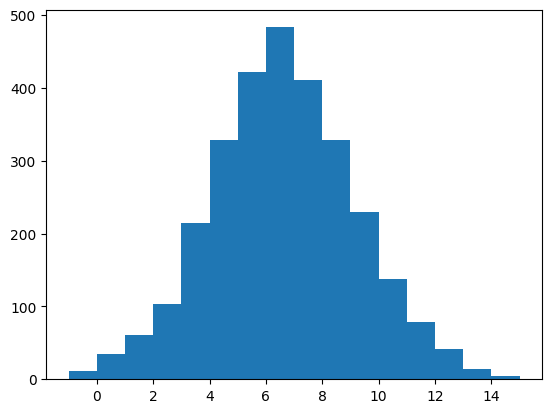

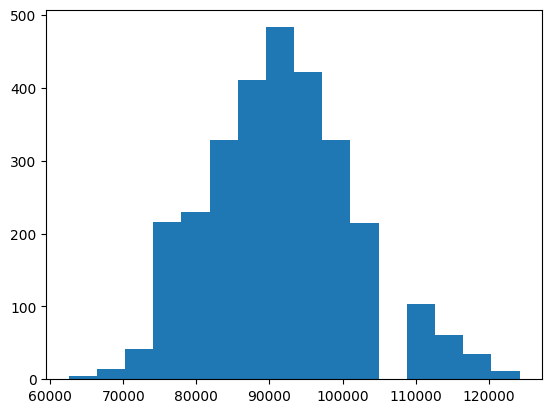

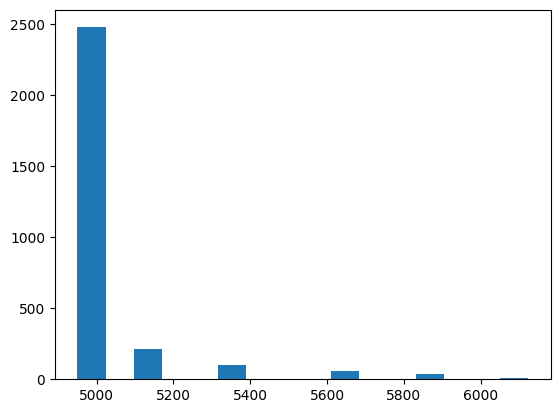

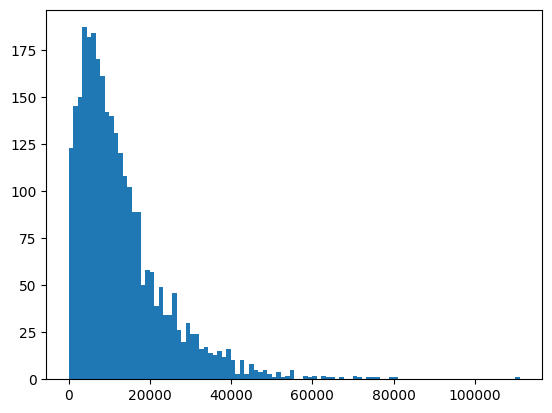

In [438]:
plt.hist(sample_ages, bins=16)
plt.show()

# histograma de IS
plt.hist(sample_is, bins=16)
plt.show()

# histograma de FRNQ
plt.hist(sample_frnq, bins=16)
plt.show()

# histograma de sinistros totais
plt.hist(sample_sinistros, bins=100)
plt.show()

In [439]:
sample = pd.DataFrame({'idade': sample_ages, 'is': sample_is, 'frnq': sample_frnq, 'sinistros_tot': sample_sinistros})
sample['tp_perda'] = np.where(sample['sinistros_tot'] > 0.5 * sample['is'] , 'T', 'P')


In [440]:
print(sample.groupby('tp_perda').size() / EXP)

tp_perda
P    0.071425
T    0.001075
dtype: float64


In [441]:
sample = sample[sample['tp_perda'] == 'P'].copy()

In [442]:
sample['indenizacao'] = (sample['sinistros_tot'] - sample['frnq']).clip(0)

print(sample['indenizacao'].sum() / sample['sinistros_tot'].sum())

0.6374107251778999


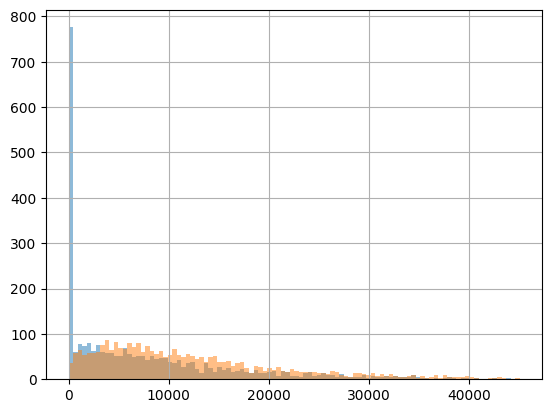

In [443]:
sample['indenizacao'].hist(bins=100, range=(0, 45000), alpha=0.5)
sample['sinistros_tot'].hist(bins=100, range=(0, 45000), alpha=0.5)
plt.show()

In [444]:
sample['indenizacao'].mean()/sample['is'].mean()

0.08516865489041013

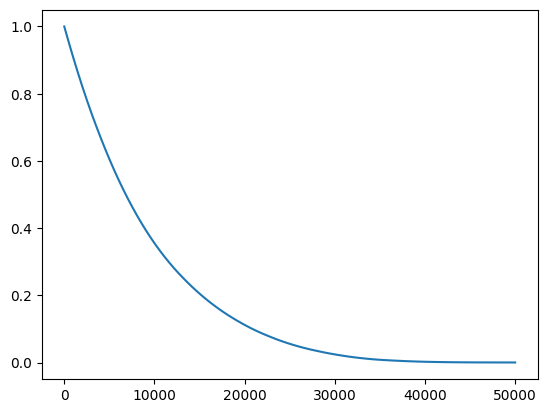

In [445]:
def variar_franquia_indenizacao(delta_frnq):
    indenizacao_0 = sample['indenizacao']
    indenizacao_p = (sample['indenizacao'] - delta_frnq).clip(0)

    ler = (indenizacao_0.sum() - indenizacao_p.sum()) / indenizacao_0.sum()

    return 1 - ler

x_trunc = np.linspace(0, 50000, 100)
y_trunc = [variar_franquia_indenizacao(x) for x in x_trunc]

plt.plot(x_trunc, y_trunc)
plt.show()

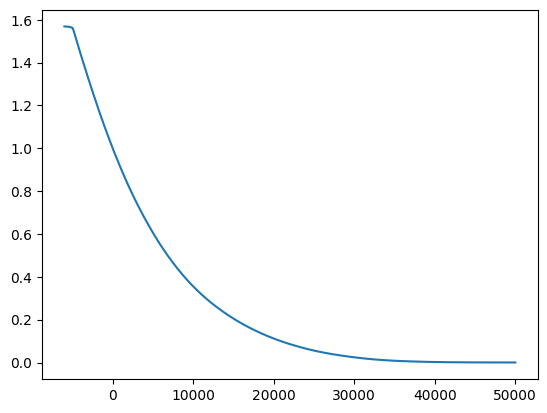

In [446]:
def variar_franquia_sinistros(delta_frnq):
    sinistros_0 = sample['indenizacao']
    sinistros_p = (sample['sinistros_tot'] - (sample['frnq'] + delta_frnq).clip(0)).clip(0)

    ler = (sinistros_0.sum() - sinistros_p.sum()) / sinistros_0.sum()

    return 1 - ler

x_tot = np.linspace(-6000, 50000, 500)
y_tot = [variar_franquia_sinistros(x) for x in x_tot]

plt.plot(x_tot, y_tot)
plt.show()

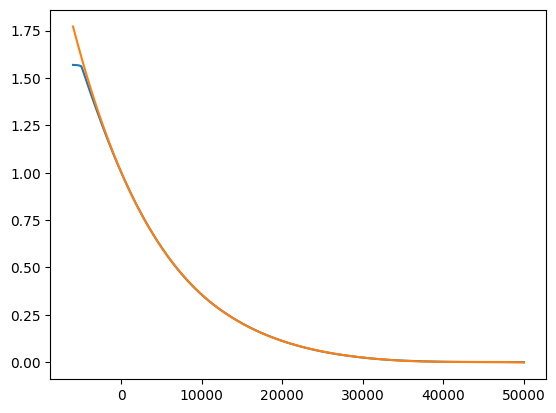

In [447]:
# fit polinomial
from numpy.polynomial.polynomial import Polynomial

# fita no truncado
p = Polynomial.fit(x_trunc, y_trunc, 5)

# avalia no total
plt.plot(x_tot, y_tot)
plt.plot(x_tot, p(x_tot))
plt.show()

In [451]:
sample['taxa_atual'] = TAXA_ATUAL
sample['vlr_minimo'] = VLR_MINIMO
sample['taxa_new'] = .045
sample['fator_idade'] = 1.03 ** (sample['idade'] - 4)

In [452]:
NEP = EXP * 4500

In [454]:
def calcular_frnq_new(row, vlr_minimo=VLR_MINIMO):
    return max(row['taxa_new'] * row['is'], vlr_minimo)*row['fator_idade']

def calcular_indenizacao_new(row):
    # if row['delta_frnq'] >= 0 :
    #     return max(row['indenizacao'] - row['delta_frnq'], 0)
    # else:
    #     return row['indenizacao'] * row['rate_delta_frnq']

    return max(row['indenizacao'] - row['delta_frnq'], 0)


def simular_movimento_loss(vlr_minimo):
    sample2 = sample.copy()
    sample2['frnq_new'] = sample2.apply(lambda x: calcular_frnq_new(x, vlr_minimo), axis=1)
    sample2['delta_frnq'] = sample2['frnq_new'] - sample2['frnq']
    sample2['rate_delta_frnq'] = (sample2['delta_frnq'].apply(lambda x: p(x))).clip(0, 1.35)
    sample2['indenizacao_new'] = sample2.apply(calcular_indenizacao_new, axis=1)

    return (sample2['indenizacao_new'].sum() / NEP)


print(sample['indenizacao'].sum() / NEP)

for v in np.linspace(0, 6000, 20):
    # calcular_movimento_loss(v)
    print(v, simular_movimento_loss(v))




def calcular_movimento_loss(vlr_minimo):
    sample['frnq_new'] = sample.apply(lambda x: calcular_frnq_new(x, vlr_minimo), axis=1)
    sample['delta_frnq'] = sample['frnq_new'] - sample['frnq']
    sample['rate_delta_frnq'] = (sample['delta_frnq'].apply(lambda x: p(x))).clip(0, 1.35)
    sample['indenizacao_new'] = sample.apply(calcular_indenizacao_new, axis=1)

    return None

calcular_movimento_loss(4736)

# 5500.0 0.6771493521085491
# 5500.0 0.6771415901686257

0.12443025265225222
0.0 0.13432160646789643
315.7894736842105 0.13432160646789643
631.578947368421 0.13432160646789643
947.3684210526316 0.13432160646789643
1263.157894736842 0.13432160646789643
1578.9473684210525 0.13432160646789643
1894.7368421052631 0.13432160646789643
2210.5263157894738 0.13432160646789643
2526.315789473684 0.13432160646789643
2842.1052631578946 0.1343207262408635
3157.894736842105 0.13430164400172226
3473.684210526316 0.13411070300945194
3789.4736842105262 0.1333238806523887
4105.263157894737 0.13137103954164372
4421.0526315789475 0.1281520993230594
4736.8421052631575 0.12433267034604363
5052.631578947368 0.12040889838157147
5368.421052631579 0.11653146141204916
5684.210526315789 0.11274812014034846
6000.0 0.10909579887519988


In [455]:
# nicho que diminui a franquia e aumenta a taxa

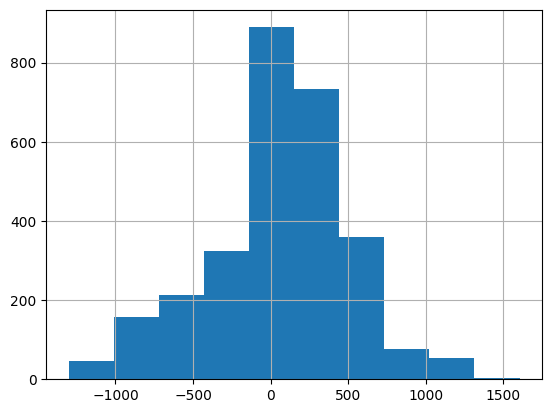

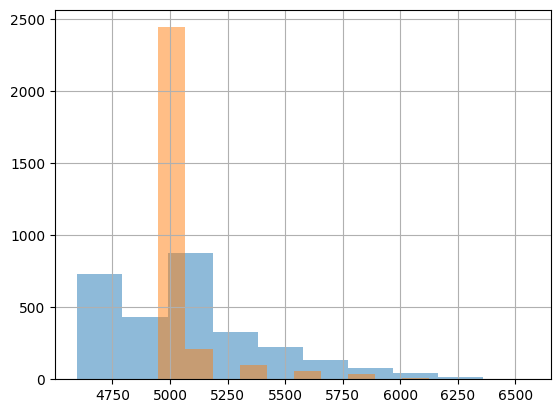

In [456]:
sample['delta_frnq'].hist()
plt.show()

sample['frnq_new'].hist(alpha=0.5)
sample['frnq'].hist(alpha=0.5)
plt.show()

In [457]:
sample.sort_values('delta_frnq', ascending=False)

,idade,is,frnq,sinistros_tot,tp_perda,indenizacao,taxa_atual,vlr_minimo,taxa_new,fator_idade,frnq_new,delta_frnq,rate_delta_frnq,indenizacao_new
1799,15.0,62522.0,4950.0000,21351.010551,P,16401.010551,0.0493,4950,0.045,1.384234,6555.731612,1605.731612,0.854045,14795.278939
682,15.0,62522.0,4950.0000,3533.453735,P,0.000000,0.0493,4950,0.045,1.384234,6555.731612,1605.731612,0.854045,0.000000
1255,15.0,62522.0,4950.0000,5535.435094,P,585.435094,0.0493,4950,0.045,1.384234,6555.731612,1605.731612,0.854045,0.000000
794,15.0,62522.0,4950.0000,9217.816804,P,4267.816804,0.0493,4950,0.045,1.384234,6555.731612,1605.731612,0.854045,2662.085192
2288,13.0,68124.0,4950.0000,814.980511,P,0.000000,0.0493,4950,0.045,1.304773,6179.405799,1229.405799,0.886675,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,-1.0,124217.0,6123.8981,4522.354408,P,0.000000,0.0493,4950,0.045,0.862609,4821.780392,-1302.117708,1.136788,1302.117708
2673,-1.0,124217.0,6123.8981,60166.108751,P,54042.210651,0.0493,4950,0.045,0.862609,4821.780392,-1302.117708,1.136788,55344.328359
767,-1.0,124217.0,6123.8981,38898.072286,P,32774.174186,0.0493,4950,0.045,0.862609,4821.780392,-1302.117708,1.136788,34076.291894
2269,-1.0,124217.0,6123.8981,6217.845642,P,93.947542,0.0493,4950,0.045,0.862609,4821.780392,-1302.117708,1.136788,1396.065251


In [180]:
# # fit exponential
# from scipy.optimize import curve_fit

# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c

# popt, pcov = curve_fit(func, x_trunc, y_trunc)

# plt.plot(x_tot, y_tot)
# plt.plot(x_tot, func(x_tot, *popt))
# plt.show()

In [171]:
p(3)

0.8145492744096379